* Comparing the stop criterion of precision is the goal with the enhanced version
* Describing the risk version

In [167]:
import numpy as np
import pandas as pd

from scipy.stats import beta

from utils_stats import (
    #hdi_ci_limits,
    successes_failures_to_hdi_ci_limits
)

from utils_viz import (
    #plot_success_rates
    plot_vhlines_lines,
)

seed = 7

In [307]:

import matplotlib.pyplot as plt
SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

FIG_WIDTH, FIG_HEIGHT = 8, 6

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=SMALL_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("axes", titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.rcParams["figure.figsize"] = FIG_WIDTH, FIG_HEIGHT
# plt.rcParams["hatch.linewidth"] = 0.2

plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

In [729]:
success_rate_null = 0.5   # this is the null hypothesis, not necessarilly true
dsuccess_rate = 0.05 #success_rate * 0.1
rope_precision_fraction = 0.8

success_rate = 0.5  #0.5 + 0.5 * dsuccess_rate  # the true value
# --------

rope_min = success_rate_null - dsuccess_rate
rope_max = success_rate_null + dsuccess_rate

# hypothesis: if precision_goal is lower, then PitG has less of
# an inconclusiveness problem but at the expense of more trials.
#precision_goal = (2 * dsuccess_rate) * rope_precision_fraction
precision_goal = (dsuccess_rate) * rope_precision_fraction # 1500 was not enough for 0.04
precision_goal = (1.5 * dsuccess_rate) * rope_precision_fraction # 1500 was not enough for 0.04


print(f"{success_rate_null:0.5}: null")
print(f"{rope_min:0.2}: ROPE min")
print(f"{rope_max:0.2}: ROPE max")
print("-" * 20)
print(f"{precision_goal:0.2}: Precision Goal")
print("-" * 20)
print(f"{success_rate:0.3}: true")

0.5: null
0.45: ROPE min
0.55: ROPE max
--------------------
0.06: Precision Goal
--------------------
0.5: true


In [730]:
experiments = 500 # number of experiments 500 #200 #300 #200
n_samples = 1500  #2500 # max number of samples in each experiement #2500 #1000 #1500

np.random.seed(seed)
samples = np.random.binomial(1, success_rate, [experiments, n_samples])

samples.shape  # (experiments, n_samples)

(500, 1500)

In [731]:
def _update_iteration_tally(iteration_dict, iteration):
    for this_iteration in range(iteration, len(iteration_dict)+1):
        iteration_dict[this_iteration] += 1

In [732]:
dict_successes_failures_hdi_limits = {}
dict_successes_failures_counter = {}

def booleans_to_rope_result(decision_accept, decision_reject_below, decision_reject_above):
    if decision_accept:
        return "within"
    elif decision_reject_below:
        return "below"
    elif decision_reject_above:
        return "above"

def successes_failures_to_hdi_limits(successes, failures):

    pair = (successes, failures)
    if pair not in dict_successes_failures_hdi_limits:
        dict_successes_failures_hdi_limits[pair] =\
            successes_failures_caculate_hdi_limits(successes, failures)
        dict_successes_failures_counter[pair] = 1
    else:
        dict_successes_failures_counter[pair] += 1

    return dict_successes_failures_hdi_limits[pair]


def successes_failures_caculate_hdi_limits(successes, failures):
    aa = int(successes)
    bb = int(failures)
    
    if not failures:
        aa += 1
        bb += 1
        
    if not successes:
        aa += 1
        bb += 1

    hdi_min, hdi_max = successes_failures_to_hdi_ci_limits(aa, bb)

    return hdi_min, hdi_max

iteration_number = np.arange(1, n_samples + 1)

method_roperesult_iteration = {}
methods = ["pitg", "epitg", "hdi_rope"]
rope_results = ["within", "below", "above"]
for method in methods:
    method_roperesult_iteration[method] = {}
    for rope_result in rope_results:
        method_roperesult_iteration[method][rope_result] = {iteration: 0 for iteration in range(1, n_samples + 1)}

#iteration_pitg_accept = {iteration: 0 for iteration in range(1, n_samples + 1)}
# iteration_pitg_below = iteration_pitg_accept.copy()
# iteration_pitg_above = iteration_pitg_accept.copy()


# iteration_epitg_accept = iteration_pitg_accept.copy()
# iteration_epitg_below = iteration_epitg_accept.copy()
# iteration_epitg_above = iteration_epitg_accept.copy()

method_stats = {"pitg": {}, "epitg": {}, "hdi_rope": {}}

for isample, sample in enumerate(samples):
    pitg_stopped = False
    hdi_rope_stopped = False

    iteration_successes = sample.cumsum()
    iteration_failures = iteration_number - iteration_successes

    for iteration, successes, failures in zip(iteration_number, iteration_successes, iteration_failures):
        final_iteration = iteration == iteration_number[-1]
        hdi_min, hdi_max = successes_failures_to_hdi_limits(successes, failures)
        #hdi_min, hdi_max = successes_failures_caculate_hdi_limits(successes, failures)

        # has the precision goal been achieved?
        precision_goal_achieved = (hdi_max - hdi_min) < precision_goal

        # is the HDI conclusively within or outside the ROPE?
        decision_accept = (hdi_min >= rope_min) & (hdi_max <= rope_max)
        decision_reject_below = hdi_max < rope_min  
        decision_reject_above = rope_max < hdi_min
        conclusive = decision_accept | decision_reject_above | decision_reject_below

        iteration_results = {"decision_iteration": iteration,
                                                 "accept": decision_accept,
                                                    "reject_below": decision_reject_below,
                                                    "reject_above": decision_reject_above,
                                                    "conclusive": conclusive,
                                                    "inconclusive": not conclusive,
                                                    "successes": successes,
                                                    "failures": failures,
                                                    "hdi_min": hdi_min,
                                                    "hdi_max": hdi_max,
                                                 }   

        if precision_goal_achieved:

            # update Precision Is The Goal Stop
            if pitg_stopped is False:
                # not applying `break` because we continue for ePiTG
                if conclusive:
                    rope_result = booleans_to_rope_result(decision_accept, decision_reject_below, decision_reject_above)
                    _update_iteration_tally(method_roperesult_iteration["pitg"][rope_result], iteration)
                method_stats["pitg"][isample] = iteration_results
                pitg_stopped = True  # sample does not continue with PITG (only ePiTG) 

            # continue with Enhance Precision Is The Goal
            if conclusive:
                rope_result = booleans_to_rope_result(decision_accept, decision_reject_below, decision_reject_above)
                _update_iteration_tally(method_roperesult_iteration["epitg"][rope_result], iteration)

            if conclusive | final_iteration:
                method_stats["epitg"][isample] = iteration_results
                if final_iteration:
                    print(f"Sample {isample} at final iteration")
                    print(method_stats["epitg"][isample])
                break
        
        elif conclusive & (hdi_rope_stopped is False):
            # case in which precision not achieved yet but conclusive.
            # this is the HDI+ROPE approach which disregards precision
            rope_result = booleans_to_rope_result(decision_accept, decision_reject_below, decision_reject_above)
            _update_iteration_tally(method_roperesult_iteration["hdi_rope"][rope_result], iteration)
            method_stats["hdi_rope"][isample] = iteration_results

            hdi_rope_stopped = True

        elif final_iteration:
            # ensures that if reached final iteration and not conclusive that
            # results are still recorded as inconclusive
            
            """
            decision_accept = False
            decision_reject_below = False
            decision_reject_above = False
            conclusive = False
            """
            if isample not in method_stats["hdi_rope"]:
               method_stats["hdi_rope"][isample] = iteration_results
            if isample not in method_stats["pitg"]:
                method_stats["pitg"][isample] = iteration_results
            if isample not in method_stats["epitg"]:
                method_stats["epitg"][isample] = iteration_results
            break


Sample 140 at final iteration
{'decision_iteration': 1500, 'accept': False, 'reject_below': False, 'reject_above': False, 'conclusive': False, 'inconclusive': True, 'successes': 708, 'failures': 792, 'hdi_min': 0.446766867411269, 'hdi_max': 0.4972694566161049}
Sample 165 at final iteration
{'decision_iteration': 1500, 'accept': False, 'reject_below': False, 'reject_above': False, 'conclusive': False, 'inconclusive': True, 'successes': 809, 'failures': 691, 'hdi_min': 0.5141054692980911, 'hdi_max': 0.5645305410768443}
Sample 169 at final iteration
{'decision_iteration': 1500, 'accept': False, 'reject_below': False, 'reject_above': False, 'conclusive': False, 'inconclusive': True, 'successes': 698, 'failures': 802, 'hdi_min': 0.4401126621762446, 'hdi_max': 0.4905728257358288}
Sample 171 at final iteration
{'decision_iteration': 1500, 'accept': False, 'reject_below': False, 'reject_above': False, 'conclusive': False, 'inconclusive': True, 'successes': 705, 'failures': 795, 'hdi_min': 0.44

In [733]:
pd.Series(dict_successes_failures_counter).value_counts(normalize=True).sort_index()

1      0.235695
2      0.109475
3      0.066701
4      0.051654
5      0.044890
         ...   
196    0.000014
197    0.000014
224    0.000014
231    0.000014
269    0.000014
Name: proportion, Length: 122, dtype: float64

In [734]:
def stats_dict_to_df(method_stats):
    df = pd.DataFrame(method_stats).T
    df.index.name = "experiment_number"
    df["precision"] = df["hdi_max"] - df["hdi_min"]
    df["success_rate"] = df["successes"] / (df["successes"] + df["failures"])
    return df


df_stats_epitg = stats_dict_to_df(method_stats["epitg"])
df_stats_epitg.head(4)

,decision_iteration,accept,reject_below,reject_above,conclusive,inconclusive,successes,failures,hdi_min,hdi_max,precision,success_rate
experiment_number,,,,,,,,,,,,
0,1065,True,False,False,True,False,517,548,0.455455,0.515448,0.059993,0.485446
1,1144,True,False,False,True,False,548,596,0.450106,0.507966,0.05786,0.479021
2,1066,True,False,False,True,False,542,524,0.478457,0.538439,0.059982,0.508443
3,1064,True,False,False,True,False,511,553,0.450278,0.510278,0.06,0.480263


In [735]:
df_stats_pitg = stats_dict_to_df(method_stats["pitg"])
df_stats_pitg.head(4)

,decision_iteration,accept,reject_below,reject_above,conclusive,inconclusive,successes,failures,hdi_min,hdi_max,precision,success_rate
experiment_number,,,,,,,,,,,,
0,1065,True,False,False,True,False,517,548,0.455455,0.515448,0.059993,0.485446
1,1064,False,False,False,False,True,507,557,0.446535,0.506515,0.05998,0.476504
2,1066,True,False,False,True,False,542,524,0.478457,0.538439,0.059982,0.508443
3,1064,True,False,False,True,False,511,553,0.450278,0.510278,0.06,0.480263


In [736]:
df_stats_hdirope = stats_dict_to_df(method_stats["hdi_rope"])
df_stats_hdirope.head(4)

,decision_iteration,accept,reject_below,reject_above,conclusive,inconclusive,successes,failures,hdi_min,hdi_max,precision,success_rate
experiment_number,,,,,,,,,,,,
0,424,True,False,False,True,False,211,213,0.45014,0.545164,0.095024,0.497642
1,443,True,False,False,True,False,223,220,0.456903,0.549872,0.092969,0.503386
2,794,True,False,False,True,False,409,385,0.48037,0.549832,0.069462,0.515113
3,597,True,False,False,True,False,293,304,0.450736,0.530843,0.080107,0.490787


In [737]:
df_stats_pitg.equals(df_stats_epitg)

False

In [738]:
def iteration_counts_to_df(roperesult_iteration, experiments):
    df = pd.DataFrame({
        "iteration": list(roperesult_iteration["within"].keys()),
        "accept": list(roperesult_iteration["within"].values()),
        "reject_below": list(roperesult_iteration["below"].values()),
        "reject_above": list(roperesult_iteration["above"].values())
    })

    df['reject'] = df['reject_above'] + df['reject_below']
    df['inconclusive'] = experiments - df['accept'] - df['reject']

    return df

df_pitg_counts = iteration_counts_to_df(method_roperesult_iteration["pitg"], experiments)
df_epitg_counts = iteration_counts_to_df(method_roperesult_iteration["epitg"], experiments)
df_hdirope_counts = iteration_counts_to_df(method_roperesult_iteration["hdi_rope"], experiments)


df_epitg_counts.head(4)


,iteration,accept,reject_below,reject_above,reject,inconclusive
0,1,0,0,0,0,500
1,2,0,0,0,0,500
2,3,0,0,0,0,500
3,4,0,0,0,0,500


In [739]:
df_epitg_counts.describe()

,iteration,accept,reject_below,reject_above,reject,inconclusive
count,1500.000000,1500.000000,1500.0,1500.0,1500.0,1500.000000
mean,750.500000,133.776667,0.0,0.0,0.0,366.223333
std,433.157015,209.537157,0.0,0.0,0.0,209.537157
min,1.000000,0.000000,0.0,0.0,0.0,15.000000
25%,375.750000,0.000000,0.0,0.0,0.0,69.000000
50%,750.500000,0.000000,0.0,0.0,0.0,500.000000
75%,1125.250000,431.000000,0.0,0.0,0.0,500.000000
max,1500.000000,485.000000,0.0,0.0,0.0,500.000000


In [740]:
df_pitg_counts.describe()

,iteration,accept,reject_below,reject_above,reject,inconclusive
count,1500.000000,1500.000000,1500.0,1500.0,1500.0,1500.000000
mean,750.500000,116.094667,0.0,0.0,0.0,383.905333
std,433.157015,181.534440,0.0,0.0,0.0,181.534440
min,1.000000,0.000000,0.0,0.0,0.0,100.000000
25%,375.750000,0.000000,0.0,0.0,0.0,100.000000
50%,750.500000,0.000000,0.0,0.0,0.0,500.000000
75%,1125.250000,400.000000,0.0,0.0,0.0,500.000000
max,1500.000000,400.000000,0.0,0.0,0.0,500.000000


In [741]:
df_pitg_counts.equals(df_epitg_counts)

False

Text(0.5, 1.0, 'true success rate = 0.500')

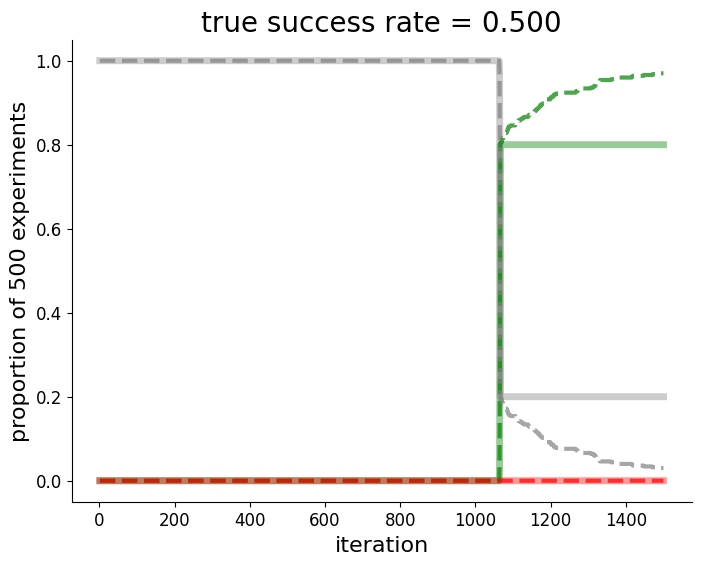

In [761]:
title = f"true success rate = {success_rate:0.3f}"
xlabel = "iteration"

iteration_values = df_pitg_counts["iteration"]


# plotting HDI+ROPE
# alpha, linewidth, linestyle = 0.2, 1, "-."
# plt.plot(iteration_values, df_hdirope_counts['accept'] / experiments, color="green", linewidth=linewidth, alpha=alpha, linestyle=linestyle)
# plt.plot(iteration_values, df_hdirope_counts['reject'] / experiments, color="red", linewidth=linewidth, alpha=alpha, linestyle=linestyle)
# plt.plot(iteration_values, df_hdirope_counts['inconclusive'] / experiments, color="gray", linewidth=linewidth, alpha=alpha, linestyle=linestyle)


# plotting pitg
alpha, linewidth = 0.4, 5
plt.plot(iteration_values, df_pitg_counts['accept'] / experiments, color="green", linewidth=linewidth, alpha=alpha)
plt.plot(iteration_values, df_pitg_counts['reject'] / experiments, color="red", linewidth=linewidth, alpha=alpha)
plt.plot(iteration_values, df_pitg_counts['inconclusive'] / experiments, color="gray", linewidth=linewidth, alpha=alpha)

# plotting epitg
alpha, linewidth, linestyle = 0.7, 3, "--"
plt.plot(iteration_values, df_epitg_counts['accept'] / experiments, color="green", linewidth=linewidth, alpha=alpha, linestyle=linestyle)
plt.plot(iteration_values, df_epitg_counts['reject'] / experiments, color="red", linewidth=linewidth, alpha=alpha, linestyle=linestyle)
plt.plot(iteration_values, df_epitg_counts['inconclusive'] / experiments, color="gray", linewidth=linewidth, alpha=alpha, linestyle=linestyle)


#plt.xscale('log')
#plt.yscale('log')
plt.xlabel(xlabel)
plt.ylabel(f"proportion of {experiments:,} experiments")
plt.title(title)


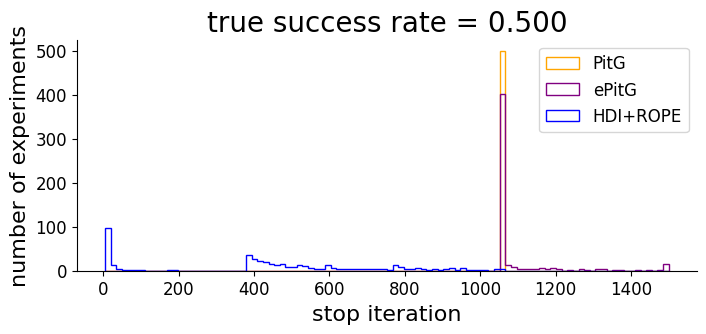

In [744]:
plt.figure(figsize=(FIG_WIDTH, 0.5 * FIG_HEIGHT))

all_values = np.concatenate([df_stats_epitg["decision_iteration"], df_stats_pitg["decision_iteration"], df_stats_hdirope["decision_iteration"] ])

_, bins = np.histogram(all_values, bins=100)

plt.hist(df_stats_pitg["decision_iteration"], bins=bins, histtype='step', label="PitG", color="orange")
plt.hist(df_stats_epitg["decision_iteration"], bins=bins, histtype='step', label="ePitG", color="purple")   
plt.hist(df_stats_hdirope["decision_iteration"], bins=bins, histtype='step', label="HDI+ROPE", color="blue")   
plt.xlabel("stop iteration")
plt.ylabel("number of experiments")
plt.legend()
plt.title(title)
pass

In [745]:
# TODO: rope_min, rope_max are not defined
def plot_pdf(sr_experiment_stats, xlim=None):
    pp = np.linspace(0, 1, 1000)
    pp_hdi = np.linspace(sr_experiment_stats["hdi_min"], sr_experiment_stats["hdi_max"], 1000)

    successes = sr_experiment_stats["successes"]
    failures = sr_experiment_stats["failures"]
    rate = successes / (successes + failures)
    n_ = successes + failures

    pdf = beta.pdf(pp, successes, failures)
    pdf_hdi = beta.pdf(pp_hdi, successes, failures)

    plt.plot(pp, pdf, color="purple", label=f"pdf p={rate:0.2f}; n={n_:,}")
    plt.fill_between(pp_hdi, pdf_hdi, color="purple", alpha=0.2, label="HDI")
    plot_vhlines_lines(vertical=rope_min, label='ROPE', horizontal=None)
    plot_vhlines_lines(vertical=rope_max, horizontal=None)
    plt.legend()
    plt.xlabel("success rate")
    plt.ylabel("probability density")

    if xlim:
        plt.xlim(xlim)
    else:
        plt.xlim([rope_min - 0.1, rope_max + 0.1])


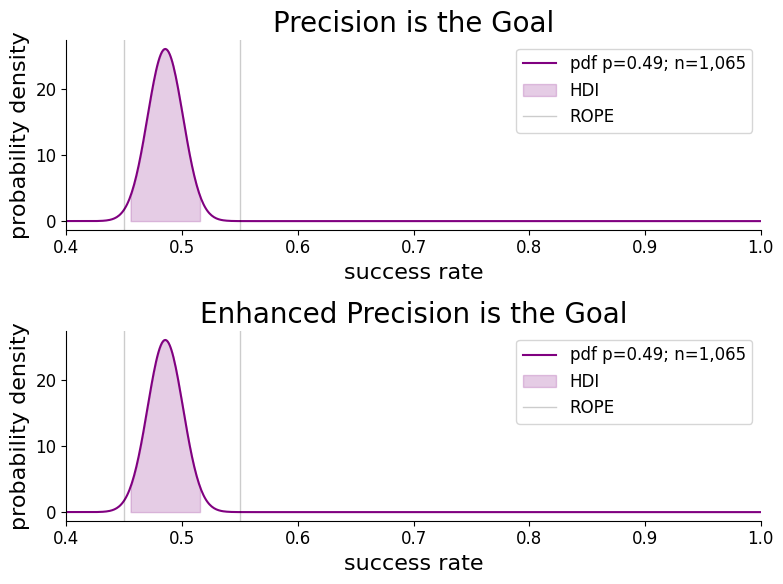

In [746]:
# experiment with the latest iteration
#idx = df_stats_epitg["decision_iteration"].astype(float).argmax()


# pitg inconclusive
#idx = df_stats_pitg.query("inconclusive").index[0]
idx = df_stats_pitg.index[0]

# ---
sr_experiment_stats_pitg = df_stats_pitg.loc[idx]
sr_experiment_stats_epitg = df_stats_epitg.loc[idx]

fig, axs = plt.subplots(2, 1, figsize=(FIG_WIDTH, FIG_HEIGHT))

plt.subplot(2, 1, 1)
plot_pdf(sr_experiment_stats_pitg, xlim=(0.4,1))
plt.title("Precision is the Goal")

plt.subplot(2, 1, 2)
plt.title("Enhanced Precision is the Goal")
plot_pdf(sr_experiment_stats_epitg, xlim=(0.4,1))
plt.tight_layout()

In [747]:
df_stats_pitg.astype(float).describe()

,decision_iteration,accept,reject_below,reject_above,conclusive,inconclusive,successes,failures,hdi_min,hdi_max,precision,success_rate
count,500.000000,500.000000,500.0,500.0,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,1065.028000,0.800000,0.0,0.0,0.800000,0.200000,531.692000,533.336000,0.469236,0.529222,0.059986,0.499228
std,1.592573,0.400401,0.0,0.0,0.400401,0.400401,17.171571,17.176996,0.016134,0.016135,0.000007,0.016142
min,1052.000000,0.000000,0.0,0.0,0.000000,0.000000,482.000000,466.000000,0.425616,0.485594,0.059967,0.455577
25%,1065.000000,1.000000,0.0,0.0,1.000000,0.000000,521.000000,522.000000,0.458765,0.518740,0.059980,0.488743
50%,1066.000000,1.000000,0.0,0.0,1.000000,0.000000,532.000000,534.000000,0.469069,0.529059,0.059988,0.499062
75%,1066.000000,1.000000,0.0,0.0,1.000000,0.000000,544.000000,545.000000,0.480322,0.540299,0.059990,0.510319
max,1066.000000,1.000000,0.0,0.0,1.000000,1.000000,586.000000,576.000000,0.527017,0.587009,0.060000,0.557034


Text(0.5, 0, 'success rate at stop')

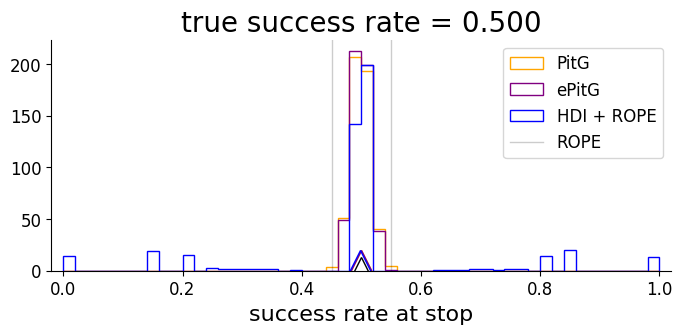

In [749]:
plt.figure(figsize=(FIG_WIDTH, 0.5 * FIG_HEIGHT))

all_values = np.concatenate([df_stats_epitg["success_rate"], df_stats_pitg["success_rate"], df_stats_hdirope["success_rate"]])
_, bins = np.histogram(all_values, bins=50)

plt.hist(df_stats_pitg["success_rate"], bins=bins, histtype='step', label="PitG", color="orange")
plt.hist(df_stats_epitg["success_rate"], bins=bins, histtype='step', label="ePitG", color="purple")
plt.hist(df_stats_hdirope["success_rate"], bins=bins, histtype='step', label="HDI + ROPE", color="blue")


# marker of truth
marker_style = dict(color='black', linestyle=':', marker='^',
                    markersize=20, markerfacecoloralt='tab:black')
plt.plot([success_rate], [0], fillstyle='none' , **marker_style)

plot_vhlines_lines(vertical=rope_min, label='ROPE', horizontal=None)
plot_vhlines_lines(vertical=rope_max, horizontal=None)

# marker of pitg
marker_style = dict(color='orange', linestyle='--', marker='^',
                    markersize=30, markerfacecoloralt='tab:orange')
plt.plot([df_stats_pitg["success_rate"].mean()], [0], **marker_style, fillstyle='none')

# marker of epitg
marker_style = dict(color='purple', linestyle=':', marker='^',
                   markersize=30, markerfacecoloralt='tab:purple')
plt.plot([df_stats_epitg["success_rate"].mean()], [0], **marker_style, fillstyle='none')

# marker of hdi+rope
marker_style = dict(color='blue', linestyle=':', marker='^',
                    markersize=30, markerfacecoloralt='tab:blue')
plt.plot([df_stats_hdirope["success_rate"].mean()], [0], **marker_style, fillstyle='none')

plt.legend()

xlim = [np.min([rope_min, all_values.min()]), np.max([rope_max, all_values.max()])]
plt.xlim([xlim[0] - 0.02, xlim[1] + 0.02])
plt.title(title)
plt.xlabel("success rate at stop")



Text(0.5, 1.0, 'true success rate = 0.500')

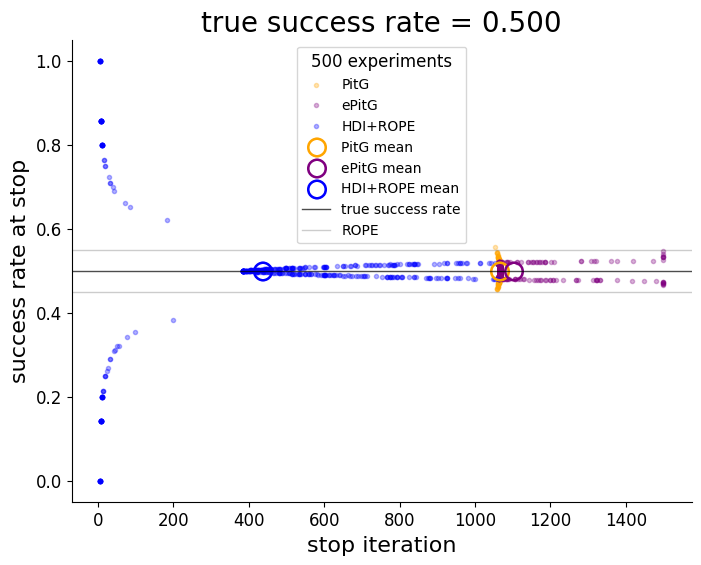

In [760]:
plt.scatter(df_stats_pitg["decision_iteration"], df_stats_pitg["success_rate"], alpha=0.3, color="orange", label="PitG", marker=".")
plt.scatter(df_stats_epitg["decision_iteration"], df_stats_epitg["success_rate"], alpha=0.3, color="purple", label="ePitG", marker=".")
plt.scatter(df_stats_hdirope["decision_iteration"], df_stats_hdirope["success_rate"], alpha=0.3, color="blue", label="HDI+ROPE", marker=".")


plt.scatter(df_stats_pitg["decision_iteration"].mean(), df_stats_pitg["success_rate"].mean(), color="orange", label="PitG mean", s=200, marker="$\u25EF$")
plt.scatter(df_stats_epitg["decision_iteration"].mean(), df_stats_epitg["success_rate"].mean(), color="purple", label="ePitG mean", s=200, marker="$\u25EF$")
plt.scatter(df_stats_hdirope["decision_iteration"].mean(), df_stats_hdirope["success_rate"].mean(), color="blue", label="HDI+ROPE mean", s=200, marker="$\u25EF$")


plot_vhlines_lines(vertical=None, label='true success rate', horizontal=success_rate, alpha=0.7)

plot_vhlines_lines(vertical=None, label='ROPE', horizontal=rope_min)
plot_vhlines_lines(vertical=None, horizontal=rope_max)
plt.xlabel("stop iteration")
plt.ylabel("success rate at stop")

plt.legend(title=f"{len(df_stats_pitg):,} experiments", loc="upper center", fontsize=10)
plt.title(title)



In [616]:
df_stats_pitg["success_rate"].mean(), df_stats_pitg["success_rate"].std()

(0.5013933279893754, 0.021614975129977804)

In [617]:
df_stats_epitg["success_rate"].mean(), df_stats_epitg["success_rate"].std()

(0.5011159577988556, 0.013766601540246995)